In [1]:
#Importing the required packages
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
import os
import re
import warnings
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

In [2]:
#We are finding all the files in our HD with help of glob function
files = glob.glob("C:/Users/sanja/telematics_data/*")

#Creating a list to merge all the files together
final_files = []

for filename in files:
    data = pd.read_csv(filename, index_col=None, header=0)
    data['VehicleId'] = int(re.findall(r'\d+',filename)[0])
    final_files.append(data)
print(final_files)

#Creating and concatinating all the files together
frame = pd.concat(final_files, axis=0, ignore_index=True)
frame.insert(2,'datetime',pd.to_datetime(frame['timestamp'],unit='s'))
frame.sort_values(by=['VehicleId','datetime'],axis=0,inplace=True)
frame

[       timestamp  longitude   latitude  mileage     speed  fuelLevel  \
0     1637190160   12.48759  55.607189      NaN  9.854212        NaN   
1     1637190160   12.48759  55.607189      NaN  9.854212        NaN   
2     1637190160   12.48759  55.607189      NaN  9.854212        NaN   
3     1637190160   12.48759  55.607189      NaN  9.854212        NaN   
4     1637190160   12.48759  55.607189      NaN  9.854212        NaN   
...          ...        ...        ...      ...       ...        ...   
1494  1637190160   12.48759  55.607189      NaN  9.854212        NaN   
1495  1637190160   12.48759  55.607189      NaN  9.854212        NaN   
1496  1637190160   12.48759  55.607189      NaN  9.854212        NaN   
1497  1637190160   12.48759  55.607189      NaN  9.854212        NaN   
1498  1637190160   12.48759  55.607189      NaN  9.854212        NaN   

      isMoving  elevation  road_type  surface_type  temp  open_weatherapi_id  \
0        False         -1        NaN           NaN -0.

,timestamp,longitude,datetime,latitude,mileage,speed,fuelLevel,isMoving,elevation,road_type,surface_type,temp,open_weatherapi_id,humidity,wind_speed,wind_deg,VehicleId
0,1637190160,12.487590,2021-11-17 23:02:40,55.607189,NaN,9.854212,NaN,False,-1,NaN,NaN,-0.26,800,89,3.09,320,1
1,1637190160,12.487590,2021-11-17 23:02:40,55.607189,NaN,9.854212,NaN,False,-1,NaN,NaN,-0.26,800,89,3.09,320,1
2,1637190160,12.487590,2021-11-17 23:02:40,55.607189,NaN,9.854212,NaN,False,-1,NaN,NaN,-0.01,800,89,3.09,320,1
3,1637190160,12.487590,2021-11-17 23:02:40,55.607189,NaN,9.854212,NaN,False,-1,NaN,NaN,-0.01,800,89,3.09,320,1
4,1637190160,12.487590,2021-11-17 23:02:40,55.607189,NaN,9.854212,NaN,False,-1,NaN,NaN,-0.01,800,89,3.09,320,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,1633092646,9.999500,2021-10-01 12:50:46,53.392792,NaN,83.610674,80.4,False,17,motorway,asphalt,17.42,800,59,6.69,200,10
2994,1633092646,9.999500,2021-10-01 12:50:46,53.392792,NaN,83.610674,80.4,False,17,motorway,asphalt,17.42,800,59,6.69,200,10
2995,1633092890,9.948216,2021-10-01 12:54:50,53.429264,NaN,69.472194,80.0,False,82,NaN,NaN,17.19,800,58,6.69,200,10
2996,1633092915,9.941238,2021-10-01 12:55:15,53.430801,NaN,73.105931,80.0,False,68,NaN,NaN,17.18,800,58,6.69,200,10


### Couting the trips by week.

In [3]:
def distance(coords_1,lat2,lon2):
    coords_2 = (lat2,lon2)
    return int(geopy.distance.geodesic(coords_1, coords_2).miles)

def TripsPerWeek(VehicalId):
    data=frame[frame['VehicleId']==VehicleId]
    data.reset_index(inplace=True)
    
    coords_1 = (data['latitude'][0],data['longitude'][0])
    
    data['distance'] = data.apply(lambda x: distance(coords_1,x['latitude'],x['longitude']), axis=1)
    data['chg'] = np.where(((data['distance'].astype(int) == 0 )& (data['distance'].shift(-1).replace(np.nan,0).astype(int) > 0 )), 1, 0)
    
    try:
        data['chg'].iat[data[data['chg']==1].index[0]]=0
    except:
        pass
    TripPerWeek=data.resample('W', on='datetime')['chg'].sum()
    TripPerWeek.plot.bar()
    print(TripPerWeek)

Enter Vehicle Id Between 1 to 10:2
datetime
2021-10-03    4
2021-10-10    4
Freq: W-SUN, Name: chg, dtype: int32


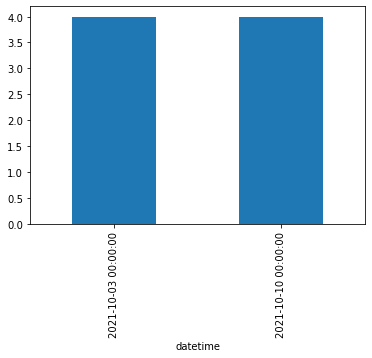

In [4]:
VehicleId = int(input("Enter Vehicle Id Between 1 to 10:"))
TripsPerWeek(VehicleId)

### Dates where refuelling were made.

In [5]:
def RefuelDate(VehicleId):
    data=frame[frame['VehicleId']==VehicleId]
    data.reset_index(inplace=True)
    fuelindex = np.where((data['fuelLevel'].diff(1))>=10, 1, 0)    
    counter = 0
    indexList=[]
    for i in np.where(fuelindex==1)[0]:
        indexList.append(i)
        print(f"DateTime = {data.iloc[i]['datetime']}, Fuel Level From {data.iloc[i-1]['fuelLevel']} To {data.iloc[i]['fuelLevel']}")
    
    data2 = data[['datetime','fuelLevel']].set_index('datetime')
    data2.plot(linestyle='-',markevery=indexList,color='b' ,marker='*',ms=15, markerfacecolor='r',figsize=(10,10))

Enter Vehicle Id Between 1 to 10:2
DateTime = 2021-09-30 09:36:29, Fuel Level From 20.4 To 100.0
DateTime = 2021-10-05 11:28:26, Fuel Level From 10.8 To 100.0


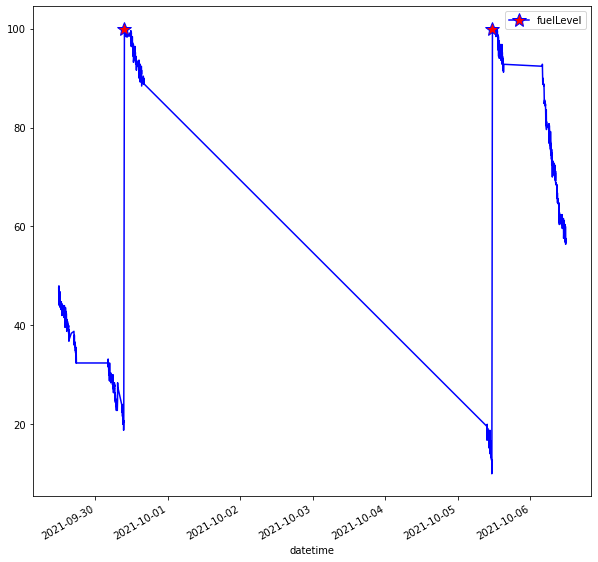

In [6]:
VehicleId = int(input("Enter Vehicle Id Between 1 to 10:"))
RefuelDate(VehicleId)

### Removing the Outliers and smoothing the FuelLevel.

Enter Vehicle Id Between 1 to 10:2
Max: 100.0 Min: 10.0


<AxesSubplot:xlabel='fuelLevel'>

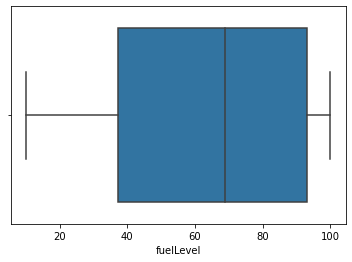

In [7]:
#Box-Plot

VehicleId = int(input("Enter Vehicle Id Between 1 to 10:"))
data=frame[frame['VehicleId']==VehicleId]
data.reset_index(inplace=True)
data['fuelLevel']=data['fuelLevel'].fillna(0)
print("Max:",max(data['fuelLevel']),"Min:",min(data['fuelLevel']))
sns.boxplot(data['fuelLevel'])

 *In all vehicle dataset fuelLevel range is fixed between 0 to 100. Now if this value is not between this range then that value will be considered as on outlier.*

<AxesSubplot:>

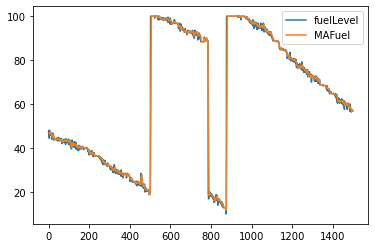

In [8]:
#Moving Average on fuelLevel
#Smoothing the data using Moving Average

data['MAFuel']=data['fuelLevel'].rolling(5).mean()
data[['fuelLevel','MAFuel']].plot()

In [9]:
#Z-Score

upper_limit = data['fuelLevel'].mean() + 0.5*data['fuelLevel'].std()
print("Highest allowed",upper_limit)
lower_limit = data['fuelLevel'].mean() - 0.5*data['fuelLevel'].std()
print("Lowest allowed",lower_limit)

Highest allowed 79.02963513674676
Lowest allowed 49.88777647099194


In [10]:
#Smoothing the FuelData by using Z-Score

data['fuelLevel'] = np.where(
    data['fuelLevel']>upper_limit,
    upper_limit,
    np.where(
        data['fuelLevel']<lower_limit,
        lower_limit,
        data['fuelLevel']
    )
)
data['fuelLevel'].describe()

count    1499.000000
mean       65.421864
std        13.464392
min        49.887776
25%        49.887776
50%        68.800000
75%        79.029635
max        79.029635
Name: fuelLevel, dtype: float64

### Deducing driving behaviour, i.e High/Low Acceleration and Braking.

In [11]:
def Driving_Behaviour(VehicleId):
    data=frame[frame['VehicleId']==VehicleId]
    data.reset_index(inplace=True)
    data["timeelapsed"]=(data.datetime - data.datetime.shift(1)).dt.total_seconds().fillna(0.00)
    data['acceleration'] = ((data['speed'] - data['speed'].shift(1)) / data["timeelapsed"]).fillna(0.00)
    data['acceleration'].plot()
    data['event']="Normal"
    data['event']=np.where(data['acceleration'] < -2.00,'High Braking',data['event'])
    data['event']=np.where(((data['acceleration'] > 1.00) & (data['acceleration'] < 2.00)),'Low Acceleration',data['event'])
    data['event']=np.where(data['acceleration'] > 2.00,'High Acceleration',data['event'])
    try:
        data['event'][~(data['event']=='Normal')].value_counts().plot(kind='bar',color='red')
        print(data['event'][~(data['event']=='Normal')].value_counts())
    except:
        print("Vehicle hasn't moved.")

Enter Vehicle Id Between 1 to 10:2
High Braking         13
Low Acceleration      7
High Acceleration     1
Name: event, dtype: int64


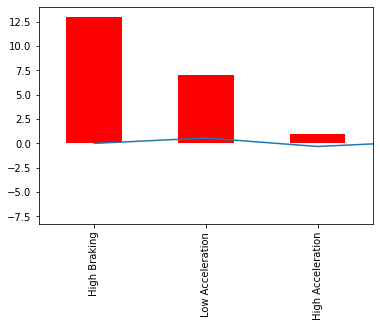

In [12]:
VehicleId = int(input("Enter Vehicle Id Between 1 to 10:"))
Driving_Behaviour(VehicleId)

### Finding out 3 Principal Components

In [13]:
pca_data = frame

In [14]:
pca_data.shape

(14990, 17)

In [15]:
pca_data.isnull().sum()

timestamp                 0
longitude                 0
datetime                  0
latitude                  0
mileage               14990
speed                     0
fuelLevel              2998
isMoving                  0
elevation                 0
road_type             10959
surface_type          11694
temp                      0
open_weatherapi_id        0
humidity                  0
wind_speed                0
wind_deg                  0
VehicleId                 0
dtype: int64

In [16]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'road_type' and 'surface_type'.
pca_data['road_type']= label_encoder.fit_transform(pca_data['road_type'])
pca_data['surface_type']= label_encoder.fit_transform(pca_data['surface_type'])

In [17]:
#Drop Duplicates
pca_data.drop_duplicates(inplace=True)

df = pca_data[['speed', 'fuelLevel', 'elevation', 'road_type',
       'surface_type', 'temp','open_weatherapi_id', 'humidity', 'wind_speed',
       'wind_deg']]

df.dropna(inplace=True)

x = df.loc[:,['speed', 'fuelLevel', 'elevation', 'road_type',
       'surface_type', 'temp','open_weatherapi_id', 'humidity', 'wind_speed',
       'wind_deg']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [20]:
scaled_data = pd.DataFrame(x, columns=df.columns[0:12])
scaled_data.head()

,speed,fuelLevel,elevation,road_type,surface_type,temp,open_weatherapi_id,humidity,wind_speed,wind_deg
0,-1.582166,-0.648584,-0.672573,0.614508,0.55259,0.979540,0.393463,0.211484,0.035792,-0.90358
1,-0.259811,-0.683971,-0.682505,0.614508,0.55259,0.979540,0.393463,0.211484,0.035792,-0.90358
2,-0.702832,-0.737052,-0.652709,0.614508,0.55259,0.976945,0.393463,0.211484,0.035792,-0.90358
3,-0.294157,-0.630891,-0.662641,0.614508,0.55259,0.976945,0.393463,0.211484,0.035792,-0.90358
4,-2.063022,-0.790132,-0.662641,0.614508,0.55259,0.976945,0.393463,0.211484,0.035792,-0.90358


In [21]:
final_data_pca = PCA(n_components=3)
pc = final_data_pca.fit_transform(scaled_data)

In [27]:
col = final_data_pca.components_
final_data = pd.DataFrame(data = pc, 
                          columns = df.columns[[col[0].argmax(),col[1].argmax(),col[2].argmax()]])
final_data.head()

,elevation,road_type,humidity
0,-1.170050,0.873478,-1.432474
1,-0.929673,0.558592,-1.048070
2,-0.996504,0.686327,-1.199042
3,-0.930359,0.550612,-1.029814
4,-1.247307,1.039877,-1.638307


### Using FOLIUM to visualise the data for the trips per vehicle

In [28]:
import folium
from branca.element import Figure

In [34]:
coords_1=frame[frame['VehicleId']==1][['latitude','longitude']].values.tolist()
coords_2=frame[frame['VehicleId']==2][['latitude','longitude']].values.tolist()
coords_3=frame[frame['VehicleId']==3][['latitude','longitude']].values.tolist()
coords_4=frame[frame['VehicleId']==4][['latitude','longitude']].values.tolist()
coords_5=frame[frame['VehicleId']==5][['latitude','longitude']].values.tolist()
coords_6=frame[frame['VehicleId']==6][['latitude','longitude']].values.tolist()
coords_7=frame[frame['VehicleId']==7][['latitude','longitude']].values.tolist()
coords_8=frame[frame['VehicleId']==8][['latitude','longitude']].values.tolist()
coords_9=frame[frame['VehicleId']==9][['latitude','longitude']].values.tolist()
coords_10=frame[frame['VehicleId']==10][['latitude','longitude']].values.tolist()

fig=Figure(height=550,width=750)
maproutes=folium.Map(tiles='OpenStreetMap')
fig.add_child(maproutes)

f1=folium.FeatureGroup("Vehicle 1")
f2=folium.FeatureGroup("Vehicle 2")
f3=folium.FeatureGroup("Vehicle 3")
f4=folium.FeatureGroup("Vehicle 4")
f5=folium.FeatureGroup("Vehicle 5")
f6=folium.FeatureGroup("Vehicle 6")
f7=folium.FeatureGroup("Vehicle 7")
f8=folium.FeatureGroup("Vehicle 8")
f9=folium.FeatureGroup("Vehicle 9")
f10=folium.FeatureGroup("Vehicle 10")



# Adding lines to the different feature groups
line_1=folium.vector_layers.PolyLine(coords_1,popup='<b>Trip of Vehicle_1</b>',tooltip='Vehicle_1',color='blue',weight=5).add_to(f1)
line_2=folium.vector_layers.PolyLine(coords_2,popup='<b>Trip of Vehicle_2</b>',tooltip='Vehicle_2',color='green',weight=5).add_to(f2)
line_3=folium.vector_layers.PolyLine(coords_3,popup='<b>Trip of Vehicle_3</b>',tooltip='Vehicle_3',color='red',weight=5).add_to(f3)
line_4=folium.vector_layers.PolyLine(coords_4,popup='<b>Trip of Vehicle_4</b>',tooltip='Vehicle_4',color='yellow',weight=5).add_to(f4)
line_5=folium.vector_layers.PolyLine(coords_5,popup='<b>Trip of Vehicle_5</b>',tooltip='Vehicle_5',color='orange',weight=5).add_to(f5)
line_6=folium.vector_layers.PolyLine(coords_6,popup='<b>Trip of Vehicle_6</b>',tooltip='Vehicle_6',color='black',weight=5).add_to(f6)
line_7=folium.vector_layers.PolyLine(coords_7,popup='<b>Trip of Vehicle_7</b>',tooltip='Vehicle_7',color='purple',weight=5).add_to(f7)
line_8=folium.vector_layers.PolyLine(coords_8,popup='<b>Trip of Vehicle_8</b>',tooltip='Vehicle_8',color='pink',weight=5).add_to(f8)
line_9=folium.vector_layers.PolyLine(coords_9,popup='<b>Trip of Vehicle_9</b>',tooltip='Vehicle_9',color='gray',weight=5).add_to(f9)
line_10=folium.vector_layers.PolyLine(coords_10,popup='<b>Trip of Vehicle_10</b>',tooltip='Vehicle_10',color='lightgreen',weight=5).add_to(f10)

f1.add_to(maproutes)
f2.add_to(maproutes)
f3.add_to(maproutes)
f4.add_to(maproutes)
f5.add_to(maproutes)
f6.add_to(maproutes)
f7.add_to(maproutes)
f8.add_to(maproutes)
f9.add_to(maproutes)
f10.add_to(maproutes)


folium.LayerControl().add_to(maproutes)
maproutes